In [1]:
# Data commands:
# distractors: `python download_data.py --project=feature_recycling-rupam_distractors_task-hyper_search --sweep vz3pljbi`
# non-stationary target: `python download_data.py --project=feature_recycling-rupam_distractors_task-hyper_search --sweeps 3gtd0r49`
# noisy target: `python download_data.py --project=feature_recycling-rupam_distractors_task-hyper_search --sweeps k3qql043`
# larger target hidden dim: `python download_data.py --project=feature_recycling-rupam_distractors_task-hyper_search --sweeps 4o0l41pg`
# more target inputs: `python download_data.py --project=feature_recycling-rupam_distractors_task-hyper_search --sweeps 6wlqr8jx`

In [2]:
import re
import sys

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from plotting_utils import *

sns.set_theme('notebook', 'white')
%matplotlib inline

In [28]:
save_path = 'figures/'
config_data_path = 'data/ablation_config_data.csv'
run_data_path = f'data/ablation_run_data.csv'

all_sweeps_config_df = pd.read_csv(config_data_path, index_col=0)
all_sweeps_config_df['run_id'] = all_sweeps_config_df['id']
all_sweeps_config_df = flatten_config_df(all_sweeps_config_df)
all_sweeps_run_df = pd.read_csv(run_data_path, index_col=0)

sweep_name_map = {
    'vz3pljbi': 'distractors',
    '3gtd0r49': 'non_stationary_target',
    'k3qql043': 'noisy_target',
    '4o0l41pg': 'target_hidden_dim',
    '6wlqr8jx': 'input_count'
}

# Split up dfs by sweep name
run_dfs = {}
config_dfs = {}
for sweep_id, sweep_name in sweep_name_map.items():
    config_dfs[sweep_name] = all_sweeps_config_df[all_sweeps_config_df['sweep'] == sweep_id].reset_index(drop=True)
    run_ids = set(config_dfs[sweep_name]['run_id'].unique())
    run_dfs[sweep_name] = all_sweeps_run_df[all_sweeps_run_df['run_id'].isin(run_ids)].reset_index(drop=True)

# Add in an extra baseline df
config_dfs['baseline'] = config_dfs['distractors'][config_dfs['distractors']['task.distractor_chance'] == 0]
vanilla_run_ids = set(config_dfs['baseline']['run_id'].unique())
run_dfs['baseline'] = run_dfs['distractors'][run_dfs['distractors']['run_id'].isin(vanilla_run_ids)]

In [45]:
def plot_ablation_figure(
        run_df, config_df, x_col, title, x_label, y_label,
        hue_col='model.hidden_dim', metric_type='cumulative', # {'cumulative', 'final'}
    ):
    if metric_type.lower() == 'cumulative':
        final_step_df = run_df.sort_values('step').groupby('run_id').last().reset_index()
        final_step_df = final_step_df.merge(config_df, on='run_id', how='left')
        y_col = 'cumulative_loss'
        y_label = f'Cumulative {y_label}'
        
    elif metric_type.lower() == 'final':
        
        
        # Get the last 5% of steps for each run
        max_steps_per_run = run_df.groupby('run_id')['step'].max()
        threshold_steps = max_steps_per_run * 0.95

        # Filter for last 5% of steps and calculate mean loss
        final_loss_df = run_df.merge(
            threshold_steps.rename('threshold_step'),
            left_on='run_id',
            right_index=True
        )
        final_loss_df = final_loss_df[final_loss_df['step'] >= final_loss_df['threshold_step']]
        final_loss_df = final_loss_df.groupby('run_id')['loss'].mean().reset_index()
        
        # Merge with config data
        final_loss_df = final_loss_df.merge(config_df, on='run_id', how='left')
        final_step_df = final_loss_df

        y_col = 'loss'
        y_label = f'{y_label} (Final 5%)'
        
    else:
        raise ValueError(f"Invalid metric type: {metric_type}!")

    # Create a mapping of actual values to evenly spaced positions
    x_values = sorted(final_step_df[x_col].unique())
    x_positions = np.arange(len(x_values))
    x_map = dict(zip(x_values, x_positions))

    # Create temporary column with evenly spaced x positions
    final_step_df['x_position'] = final_step_df[x_col].map(x_map)

    # Create plot with evenly spaced x positions
    sns.lineplot(
        data = final_step_df,
        x = 'x_position',
        y = y_col, 
        hue = hue_col,
        marker = 'o',
        palette = 'deep',
        errorbar = None,
    )

    # Customize plot
    plt.grid(True, alpha=0.4)  # Add light grid
    plt.xlim(-0.1, len(x_values) - 0.9)  # Add small padding on both sides
    plt.xticks(x_positions, x_values)  # Use original values as labels
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(title='# Hidden Units')

In [52]:
def plot_learning_curves(
        run_df,
        config_df,
        subplot_col,
        subplot_values = None,
        n_bins = 200,
        figsize = (12, 10),
        max_cols = 2,
        subplot_col_label = None,
    ):
    """Creates subplots of learning curves for different values of a variable.
    
    Args:
        run_df: DataFrame containing run data
        config_df: DataFrame containing config data
        subplot_col: Column name to split subplots by
        subplot_values: List of values to plot. If None, uses all unique values
        n_bins: Number of bins for the learning curves
        figsize: Figure size as (width, height) tuple
        max_cols: Maximum number of columns in subplot grid
        subplot_col_label: Label for the subplot column
    """
    # Get full dataset
    plot_df = run_df.merge(config_df, on='run_id', how='left')
    
    # Get subplot values if not provided
    if subplot_values is None:
        subplot_values = sorted(plot_df[subplot_col].unique())
    
    # Calculate number of rows/cols for subplots
    n_plots = len(subplot_values)
    n_cols = min(max_cols, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Calculate mid 98% percentile for consistent y-axis
    filtered_df = plot_df[
        (plot_df['loss'] >= np.percentile(plot_df['loss'], 1)) &
        (plot_df['loss'] <= np.percentile(plot_df['loss'], 99))
    ]
    y_range = filtered_df['loss'].max() - filtered_df['loss'].min()
    y_pad = y_range * 0.1
    y_min = filtered_df['loss'].min() - y_pad
    y_max = filtered_df['loss'].max() + y_pad

    # Get max step value for x-axis limit
    max_step = plot_df['step'].max()

    for i, val in enumerate(subplot_values):
        # Filter for current value
        curr_df = plot_df[plot_df[subplot_col] == val].copy()
        
        # Bin data
        curr_df = bin_df(curr_df, n_bins=n_bins)
        curr_df = curr_df[curr_df['model.hidden_dim'].notna()]  # Remove NaN values
        curr_df['model.hidden_dim'] = curr_df['model.hidden_dim'].astype(int)
        
        # Create subplot
        sns.lineplot(
            data = curr_df,
            x = 'step',
            y = 'loss',
            hue = 'model.hidden_dim', 
            palette = 'deep',
            errorbar = None,
            ax = axes[i]
        )
        
        # Customize subplot
        axes[i].grid(True, alpha=0.4)
        axes[i].set_xlim(0, max_step)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_title(f'{subplot_col_label if subplot_col_label else subplot_col} = {val}')
        axes[i].set_xlabel('step (binned)')
        axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        axes[i].set_ylabel('loss')
        
        # Only show legend on first subplot
        if i > 0:
            axes[i].get_legend().remove()
        else:
            axes[i].legend(title='# Hidden Units')
    
    # Remove any extra subplots
    for i in range(len(subplot_values), len(axes)):
        fig.delaxes(axes[i])
    
    # Add overall title if provided
    if subplot_col_label:
        plt.suptitle(f'Learning Curves for {subplot_col_label}')
        
    plt.tight_layout()

## Input Feature Count Ablation

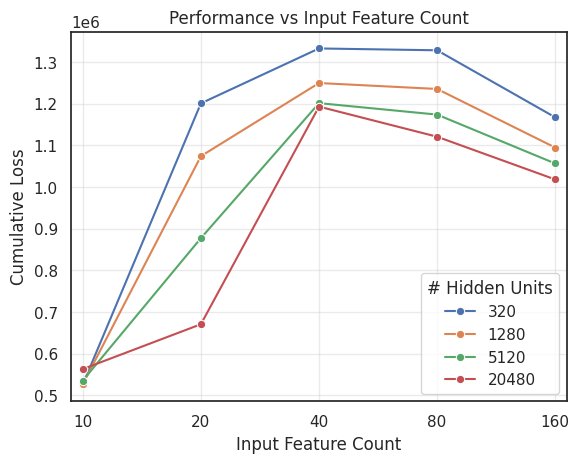

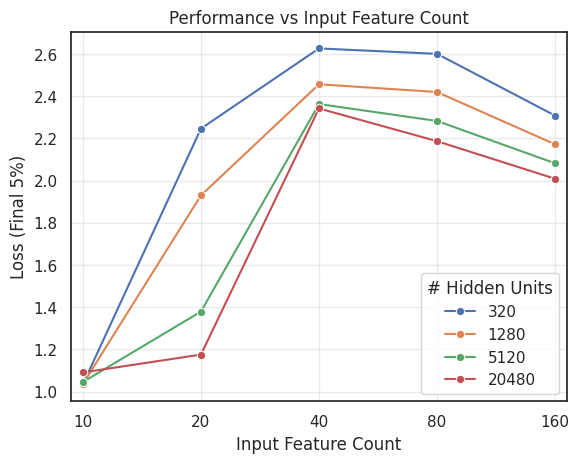

In [46]:
kwargs = {
    'run_df': run_dfs['input_count'],
    'config_df': config_dfs['input_count'],
    'x_col': 'task.n_features',
    'title': 'Performance vs Input Feature Count',
    'x_label': 'Input Feature Count',
    'y_label': 'Loss',
}

plot_ablation_figure(**kwargs, metric_type='cumulative')
plt.show()
plot_ablation_figure(**kwargs, metric_type='final')
plt.show()

## Distractor Count Ablation

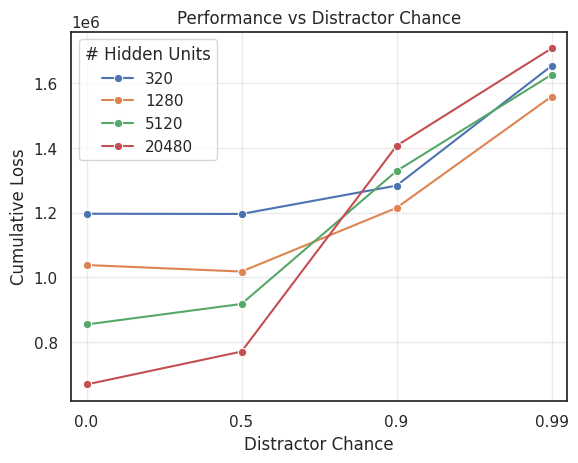

In [18]:
final_step_df = run_dfs['distractors'].sort_values('step').groupby('run_id').last().reset_index()
final_step_df = final_step_df.merge(config_dfs['distractors'], on='run_id', how='left')

# Create a mapping of actual values to evenly spaced positions
x_values = sorted(final_step_df['task.distractor_chance'].unique())
x_positions = np.arange(len(x_values))
x_map = dict(zip(x_values, x_positions))

# Create temporary column with evenly spaced x positions
final_step_df['x_position'] = final_step_df['task.distractor_chance'].map(x_map)

# Create plot with evenly spaced x positions
sns.lineplot(
    data = final_step_df,
    x = 'x_position',
    y = 'cumulative_loss', 
    hue = 'model.hidden_dim',
    marker = 'o',
    palette = 'deep',
    errorbar = None,
)

# Customize plot
plt.grid(True, alpha=0.4)  # Add light grid
plt.xlim(-0.1, len(x_values) - 0.9)  # Add small padding on both sides
plt.xticks(x_positions, x_values)  # Use original values as labels
plt.title('Performance vs Distractor Chance')
plt.xlabel('Distractor Chance')
plt.ylabel('Cumulative Loss')
plt.legend(title='# Hidden Units')

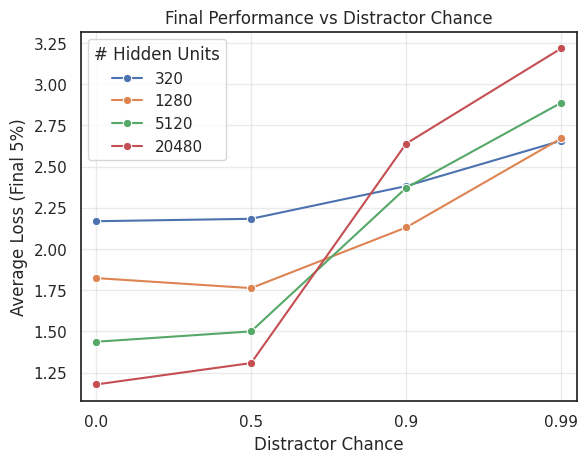

In [20]:
# Get the last 5% of steps for each run
max_steps_per_run = run_dfs['distractors'].groupby('run_id')['step'].max()
threshold_steps = max_steps_per_run * 0.95

# Filter for last 5% of steps and calculate mean loss
final_loss_df = run_dfs['distractors'].merge(
    threshold_steps.rename('threshold_step'),
    left_on='run_id',
    right_index=True
)
final_loss_df = final_loss_df[final_loss_df['step'] >= final_loss_df['threshold_step']]
final_loss_df = final_loss_df.groupby('run_id')['loss'].mean().reset_index()

# Merge with config data
final_loss_df = final_loss_df.merge(config_dfs['distractors'], on='run_id', how='left')

# Create a mapping of actual values to evenly spaced positions
x_values = sorted(final_loss_df['task.distractor_chance'].unique())
x_positions = np.arange(len(x_values))
x_map = dict(zip(x_values, x_positions))

# Create temporary column with evenly spaced x positions
final_loss_df['x_position'] = final_loss_df['task.distractor_chance'].map(x_map)

# Create plot with evenly spaced x positions
sns.lineplot(
    data = final_loss_df,
    x = 'x_position',
    y = 'loss',
    hue = 'model.hidden_dim',
    marker = 'o',
    palette = 'deep',
    errorbar = None,
)

# Customize plot
plt.grid(True, alpha=0.4)  # Add light grid
plt.xlim(-0.1, len(x_values) - 0.9)  # Add small padding on both sides
plt.xticks(x_positions, x_values)  # Use original values as labels
plt.title('Final Performance vs Distractor Chance')
plt.xlabel('Distractor Chance')
plt.ylabel('Average Loss (Final 5%)')
plt.legend(title='# Hidden Units')

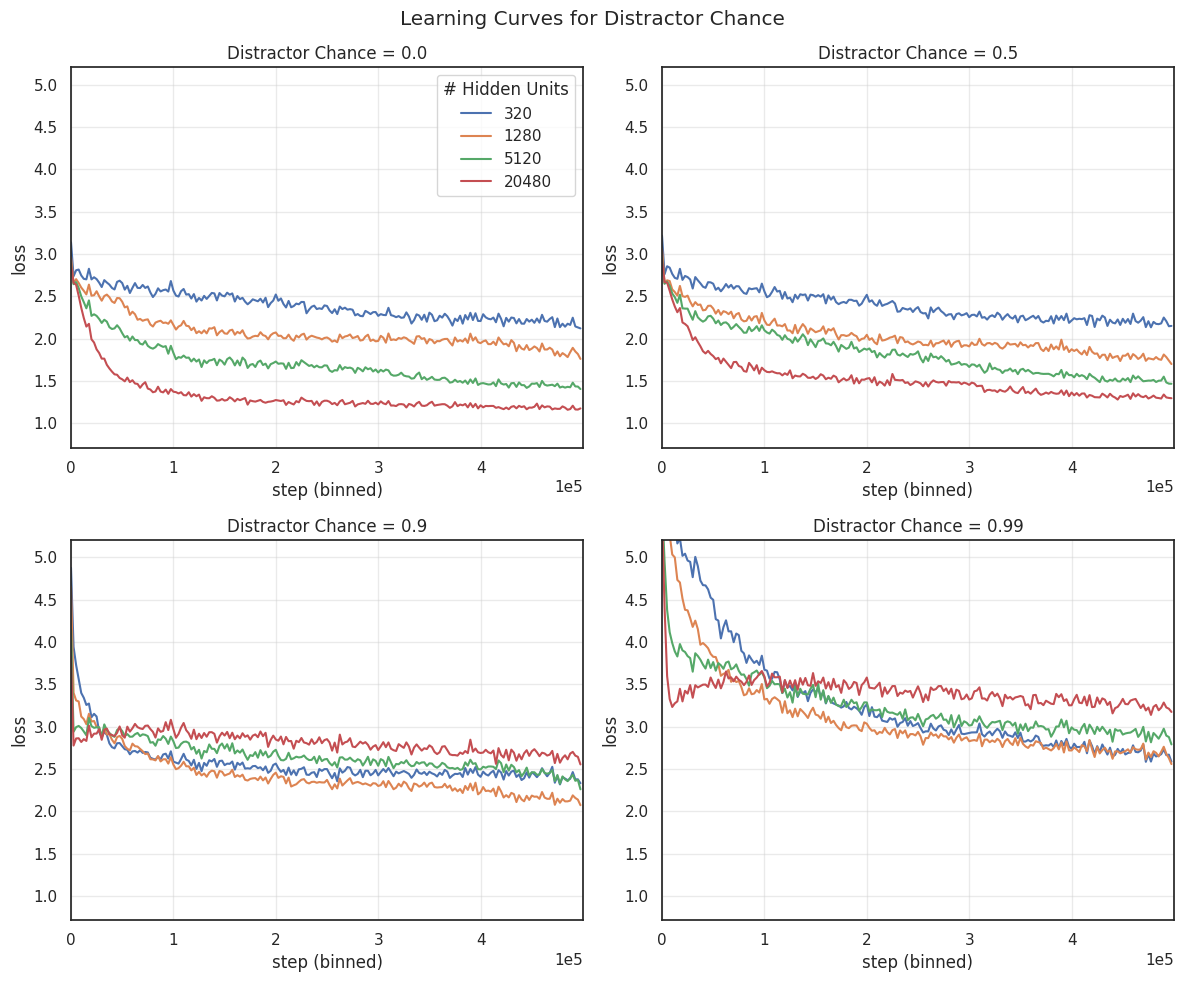

In [53]:
plot_learning_curves(
    run_df = run_dfs['distractors'],
    config_df = config_dfs['distractors'],
    subplot_col = 'task.distractor_chance',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Distractor Chance',
)

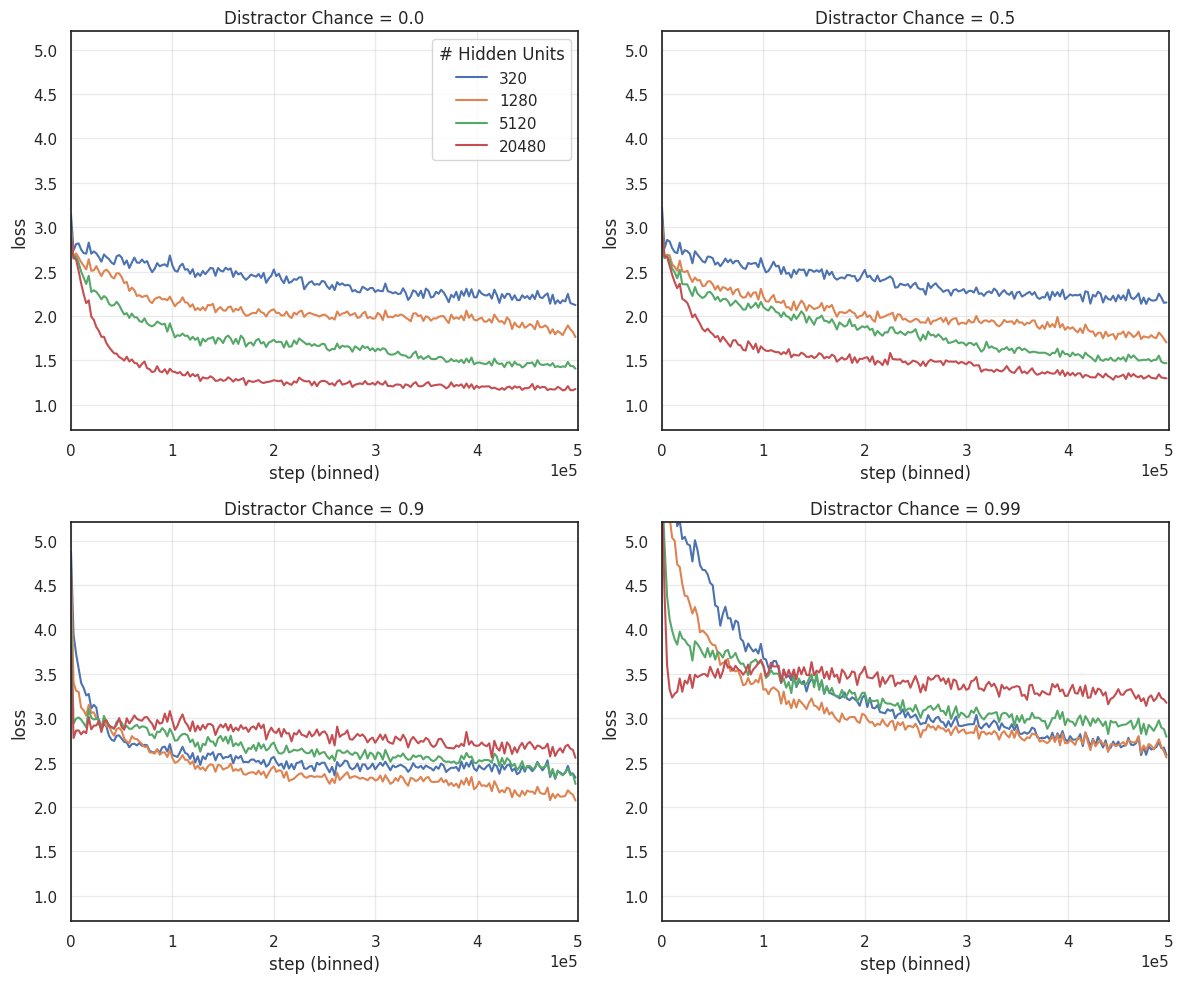

In [21]:
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

distractor_chances = [0.0, 0.5, 0.9, 0.99]

# Get full dataset
plot_df = run_dfs['distractors'].merge(config_dfs['distractors'], on='run_id', how='left')

# Calculate mid 98% percentile for consistent y-axis
filtered_df = plot_df[
    (plot_df['loss'] >= np.percentile(plot_df['loss'], 1)) &
    (plot_df['loss'] <= np.percentile(plot_df['loss'], 99))
]
y_range = filtered_df['loss'].max() - filtered_df['loss'].min()
y_pad = y_range * 0.1
y_min = filtered_df['loss'].min() - y_pad
y_max = filtered_df['loss'].max() + y_pad

for i, dc in enumerate(distractor_chances):
    # Filter for current distractor chance
    curr_df = plot_df[plot_df['task.distractor_chance'] == dc].copy()
    
    # Bin data
    curr_df = bin_df(curr_df, n_bins=200)
    curr_df = curr_df[curr_df['model.hidden_dim'].notna()]  # Remove NaN values
    curr_df['model.hidden_dim'] = curr_df['model.hidden_dim'].astype(int)
    
    # Create subplot
    sns.lineplot(
        data = curr_df,
        x = 'step',
        y = 'loss',
        hue = 'model.hidden_dim', 
        palette = 'deep',
        errorbar = None,
        ax = axes[i]
    )
    
    # Customize subplot
    axes[i].grid(True, alpha=0.4)
    axes[i].set_xlim(0, 500_000)
    axes[i].set_ylim(y_min, y_max)
    axes[i].set_title(f'Distractor Chance = {dc}')
    axes[i].set_xlabel('step (binned)')
    axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axes[i].set_ylabel('loss')
    
    # Only show legend on first subplot
    if i > 0:
        axes[i].get_legend().remove()
    else:
        axes[i].legend(title='# Hidden Units')

plt.tight_layout()

## Target Non-Stationarity Ablation

In [23]:
nst_config_df = config_dfs['non_stationary_target']
nst_run_df = run_dfs['non_stationary_target']

In [24]:
# Correct flip_rate column
if nst_config_df['task.flip_rate'].dtype == 'object':
    nst_config_df['task.flip_rate'] = nst_config_df['task.flip_rate'].apply(
        lambda x: eval(re.match(r'\${eval:(.*)}', x).group(1)))

In [25]:
augmented_nst_config_df = pd.concat([config_dfs['baseline'], nst_config_df])
augmented_nst_run_df = pd.concat([run_dfs['baseline'], nst_run_df])

/tmp/ipykernel_7612/2377770783.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['x_position'] = df1['task.flip_rate'].map(x_map1)
/tmp/ipykernel_7612/2377770783.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['x_position'] = df2['task.flip_rate'].map(x_map2)


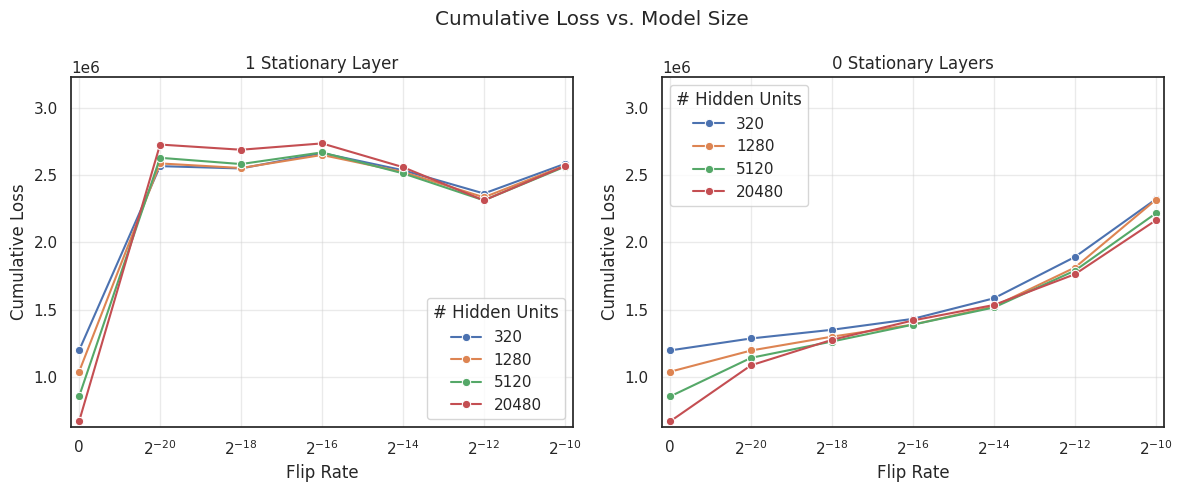

In [26]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Cumulative Loss vs. Model Size')

# Process data for both plots
final_step_df = augmented_nst_run_df.sort_values('step').groupby('run_id').last().reset_index()
final_step_df = final_step_df.merge(augmented_nst_config_df, on='run_id', how='left')

# Data for first subplot (n_stationary_layers = 1)
df1 = final_step_df[
    (final_step_df['task.n_stationary_layers'] == 1) |
    (final_step_df['task.flip_rate'] == 0)
]
x_values1 = sorted(df1['task.flip_rate'].unique())
x_positions1 = np.arange(len(x_values1))
x_map1 = dict(zip(x_values1, x_positions1))
df1['x_position'] = df1['task.flip_rate'].map(x_map1)

# Data for second subplot (n_stationary_layers = 0)
df2 = final_step_df[
    (final_step_df['task.n_stationary_layers'] == 0) |
    (final_step_df['task.flip_rate'] == 0)
]
x_values2 = sorted(df2['task.flip_rate'].unique())
x_positions2 = np.arange(len(x_values2))
x_map2 = dict(zip(x_values2, x_positions2))
df2['x_position'] = df2['task.flip_rate'].map(x_map2)

# Calculate overall y limits
y_min = min(df1['cumulative_loss'].min(), df2['cumulative_loss'].min())
y_max = max(df1['cumulative_loss'].max(), df2['cumulative_loss'].max())

# First subplot
sns.lineplot(
    data=df1,
    x='x_position',
    y='cumulative_loss',
    hue='model.hidden_dim',
    marker='o',
    palette='deep',
    errorbar=None,
    ax=ax1
)

ax1.grid(True, alpha=0.4)
ax1.set_xlim(-0.1, len(x_values1) - 0.9)
ax1.set_ylim(y_min, y_max)
ax1.set_xticks(x_positions1)
ax1.set_xticklabels([f'{"0" if x == 0 else f"$2^{{{int(np.log2(x))}}}$"}' for x in x_values1])
ax1.set_title('1 Stationary Layer')
ax1.set_xlabel('Flip Rate')
ax1.set_ylabel('Cumulative Loss')
ax1.legend(title='# Hidden Units')

# Second subplot
sns.lineplot(
    data=df2,
    x='x_position',
    y='cumulative_loss',
    hue='model.hidden_dim',
    marker='o',
    palette='deep',
    errorbar=None,
    ax=ax2
)

ax2.grid(True, alpha=0.4)
ax2.set_xlim(-0.1, len(x_values2) - 0.9)
ax2.set_ylim(y_min, y_max)
ax2.set_xticks(x_positions2)
ax2.set_xticklabels([f'{"0" if x == 0 else f"$2^{{{int(np.log2(x))}}}$"}' for x in x_values2])
ax2.set_title('0 Stationary Layers')
ax2.set_xlabel('Flip Rate')
ax2.set_ylabel('Cumulative Loss')
ax2.legend(title='# Hidden Units')

plt.tight_layout()

/tmp/ipykernel_7612/3986293652.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['x_position'] = df1['task.flip_rate'].map(x_map1)
/tmp/ipykernel_7612/3986293652.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['x_position'] = df2['task.flip_rate'].map(x_map2)


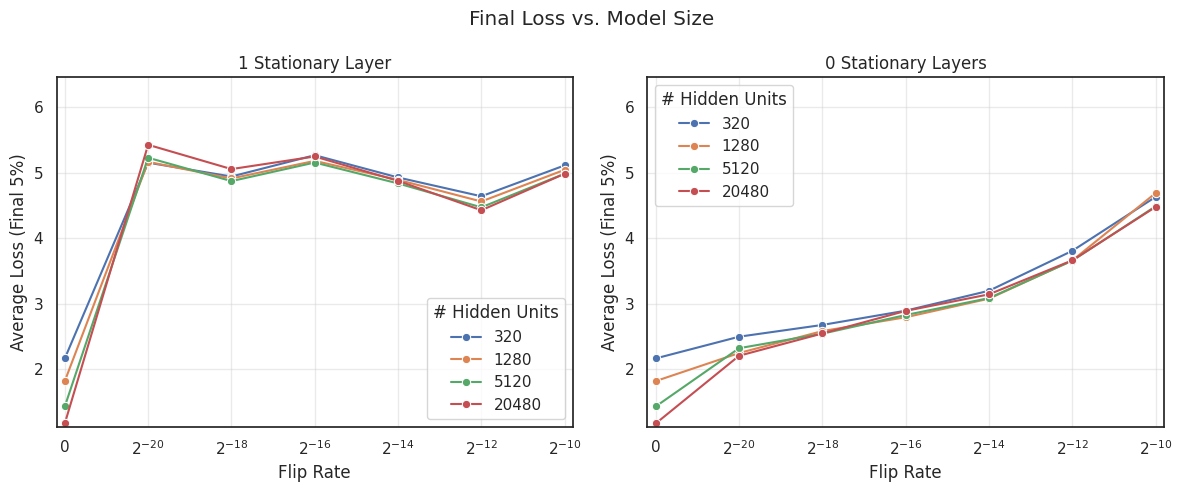

In [27]:
# Get the last 5% of steps for each run
max_steps_per_run = augmented_nst_run_df.groupby('run_id')['step'].max()
threshold_steps = max_steps_per_run * 0.95

# Filter for last 5% of steps and calculate mean loss
final_step_df = augmented_nst_run_df.merge(
    threshold_steps.rename('threshold_step'),
    left_on='run_id',
    right_index=True
)
final_step_df = final_step_df[final_step_df['step'] >= final_step_df['threshold_step']]
final_step_df = final_step_df.groupby('run_id')['loss'].mean().reset_index()

# Merge with config data
final_step_df = final_step_df.merge(augmented_nst_config_df, on='run_id', how='left')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Final Loss vs. Model Size')

# Data for first subplot (n_stationary_layers = 1)
df1 = final_step_df[
    (final_step_df['task.n_stationary_layers'] == 1) |
    (final_step_df['task.flip_rate'] == 0)
]
x_values1 = sorted(df1['task.flip_rate'].unique())
x_positions1 = np.arange(len(x_values1))
x_map1 = dict(zip(x_values1, x_positions1))
df1['x_position'] = df1['task.flip_rate'].map(x_map1)

# Data for second subplot (n_stationary_layers = 0)
df2 = final_step_df[
    (final_step_df['task.n_stationary_layers'] == 0) |
    (final_step_df['task.flip_rate'] == 0)
]
x_values2 = sorted(df2['task.flip_rate'].unique())
x_positions2 = np.arange(len(x_values2))
x_map2 = dict(zip(x_values2, x_positions2))
df2['x_position'] = df2['task.flip_rate'].map(x_map2)

# Calculate overall y limits
y_min = min(df1['loss'].min(), df2['loss'].min())
y_max = max(df1['loss'].max(), df2['loss'].max())

# First subplot
sns.lineplot(
    data=df1,
    x='x_position',
    y='loss',
    hue='model.hidden_dim',
    marker='o',
    palette='deep',
    errorbar=None,
    ax=ax1
)

ax1.grid(True, alpha=0.4)
ax1.set_xlim(-0.1, len(x_values1) - 0.9)
ax1.set_ylim(y_min, y_max)
ax1.set_xticks(x_positions1)
ax1.set_xticklabels([f'{"0" if x == 0 else f"$2^{{{int(np.log2(x))}}}$"}' for x in x_values1])
ax1.set_title('1 Stationary Layer')
ax1.set_xlabel('Flip Rate')
ax1.set_ylabel('Average Loss (Final 5%)')
ax1.legend(title='# Hidden Units')

# Second subplot
sns.lineplot(
    data=df2,
    x='x_position',
    y='loss',
    hue='model.hidden_dim',
    marker='o',
    palette='deep',
    errorbar=None,
    ax=ax2
)

ax2.grid(True, alpha=0.4)
ax2.set_xlim(-0.1, len(x_values2) - 0.9)
ax2.set_ylim(y_min, y_max)
ax2.set_xticks(x_positions2)
ax2.set_xticklabels([f'{"0" if x == 0 else f"$2^{{{int(np.log2(x))}}}$"}' for x in x_values2])
ax2.set_title('0 Stationary Layers')
ax2.set_xlabel('Flip Rate')
ax2.set_ylabel('Average Loss (Final 5%)')
ax2.legend(title='# Hidden Units')

plt.tight_layout()